# Adaboost 与 KNN

参考【邓展鹰. 改进的AdaBoost集成学习方法研究[D].暨南大学,2021.DOI:10.27167/d.cnki.gjinu.2020.001350.】以及【Zhu, H. Zou, S. Rosset, T. Hastie, “Multi-class AdaBoost”, 2009.】https://blog.csdn.net/weixin_43298886/article/details/110927084

## Adaboost思路

Adaboost来强化一个KNN分类器，初始的时候，就是最一般的KNN，各个数据的权重是$\frac{1}{n}$，这样分类后会出现分错的情况，然后再调整权重。因此，实际上再进行下一轮KNN时，已经不是常规意义的KNN，而是**带有权重**的KNN

## 加权的KNN具体含义

例子：比如 $k=3$ ，则先找三个最邻近的点，它们权重分别为A(0.3)，A(0.6)，B(0.7)，0.9>0.7 因此，以最后择归到A类中

可以看出，其实这就是一个投票池系统，每来一个新的点，就先找k个最近，然后再发动这k个带权重投票，投票值最大的类胜出；再来一个点，再发动一次找最近，再投……。

## 代码解释

下面这段代码的基础版本是普通KNN代码如下：

```python
class KNN(nn.Module):
    def __init__(self, k):
        super(KNN, self).__init__()
        self.k = k

    def forward(self, x_train, y_train, x_test):
        dists = torch.cdist(x_test, x_train)  # 计算测试样本与训练样本之间的距离，输出是：第一行是test中的第一个和train中的每一个分别的欧氏距离，第二行是test中第二个和train中每一个的欧氏距离
        _, indices = torch.topk(dists, self.k, largest=False)  # 选择最近的 K个样本的索引，存在indices中
        
        knn_labels = y_train[indices]  # 获取最近的K个样本的标签,knn_labels中的每一列都是y_train[某个indice],即类似于[[1],
 09]]
        pred_labels, _ = torch.mode(knn_labels, dim=1)  # 进行投票，选择出现次数最多的标签
        return pred_label

# 使用示例
k = 1
x_train = torch.tensor([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0], [1.2, 2.0]])
y_train = torch.tensor([9, 1, 9, 9])

x_test = torch.tensor([[2.5, 3.5], [1.0, 2.0]])

knn = KNN(k)

print(torch.cdist(x_test, x_train))
pred_labels = knn(x_train, y_train, x_test)
print(pred_labels)s
```

我基于加权重的KNN修改了最后投票一步，先解释原本torch.mode(knn_labels, dim=1)的意思，它knn_labels中沿着dim=1这个维度上，出现最多次数的值选出来 
现在我想把它改置一个投票池，k个最近的点带有权重进行投，因此我需要遍历各个类，让y_train[indices]=“该类”的那些权重相加，落入池中

注意：我新建一个投票池，列数本来应该是类的个数，但因为未知类的个数，不妨就取输入几个样本，就有几个列，因为样本数一定大于类的个数，因此，类别数不能乱写，比如一共就4个样本，不能有样本是第9类的，规范是：输入n个样本，它们的类别数从0开始，最多是0~n-1类（每个都自成一类的极端情况）

这个投票池叫做vote_pool，x_test中有几个要分类的，那么vote_pool就有几行，每行都各自投票，投完之后，第一行票数最高的是某个指标，就代表x_test中的第一个点要归到该指标对应的类里去才对，第二行票数最高的是某个指标，就代表x_test中的第二个点要归到该指标对应的类里去才对，以此类推

In [116]:
# 版本一

import torch
import torch.nn as nn
import torch.nn.functional as F

class KNN(nn.Module):
    def __init__(self, k):
        super(KNN, self).__init__()
        self.k = k

    def forward(self, x_train, y_train, x_test,w_train):
        dists = torch.cdist(x_test, x_train)  # 计算测试样本与训练样本之间的距离，输出是：第一行是test中的第一个和train中的每一个分别的欧氏距离，第二行是test中第二个和train中每一个的欧氏距离
        _, indices = torch.topk(dists, self.k, largest=False)  # 选择最近的 K个样本的索引，存在indices中
        
        knn_labels = y_train[indices]  # 获取最近的K个样本的标签
        # print(y_train[indices])

        vote_pool=torch.zeros(x_test.size()[0],x_train.size()[0])  #新建一个投票池，列数本来应该是类的个数，但因为未知类的个数，不妨就取train几个样本，就有几个列，因为样本数一定大于类的个数，因此，类别数不能乱写，比如一共就4个样本，不能有样本是第9类的
        #print("vote init",vote_pool)
        
        #print("hey",indices.size()[0])
        for j in range(0, indices.size()[0]):
            # print("this is j",j)
            
            for i in indices[j]:  #对于每一个x_test都有各自的投票池，这是给第j个池子投票
                #print("this",i)   #i的含义就是哪几个是k个最近点
                vote_pool[j][y_train[i]] += w_train[i] # y_train[i]表示i所在类的那个指标，往这个类的投票箱子里投权重那么多票
        
        #print("vote number",vote_pool)
        #下面开始每一行各归某一行统票
        max_indices = torch.argmax(vote_pool, dim=1) #torch.argmax对于dim=1这个维度考察，找到票数最多的，存入1行多列的max_indices中
       
        #print("max_indices",max_indices) 
        
        #这个max_indices代表胜出的类，第一个分量就是x_test中的第一个点应该归到的类，第二个分量就是x_test中第二个点应该归到的类
        return max_indices

In [117]:
# 使用示例
k = 3
x_train = torch.tensor([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0], [1.2, 2.0],[3.2,4.5]])
y_train = torch.tensor([0, 2, 1, 0, 2])
w_train = torch.tensor([0.25,0.25,0.25,0.25,0.25]) #权重，可以自己设置
# print(x_train.size()[0])
x_test = torch.tensor([[2.5, 3.5], [1.0, 2.0]])

knn = KNN(k)

#print(torch.cdist(x_test, x_train))
pred_labels = knn(x_train, y_train, x_test,w_train)
print(pred_labels)

tensor([2, 0])


## 小结

到此为止，已经实现了一轮带权重的KNN分类，目前权重w_train还不会自动更新，下面就将升级为版本2，加入权重调整函数，然后，还需要将w_train设置为能输入的并且会输出的变量，在每一次更新不断调整它

对于某一个分类错误的点，他在下一轮可能会成为train数据集（这个滚动随机抽取机制后面再实现），我们先计算出其权重应该如何变化，先计算目前分类器的分类误差率e，然后得出系数alpha，然后更新训练数据集的权值分布。注意！这里train的数据权重不会改变，而test的权重的改变根据是https://blog.csdn.net/weixin_43298886/article/details/110927084中所述的公式进行改变，即

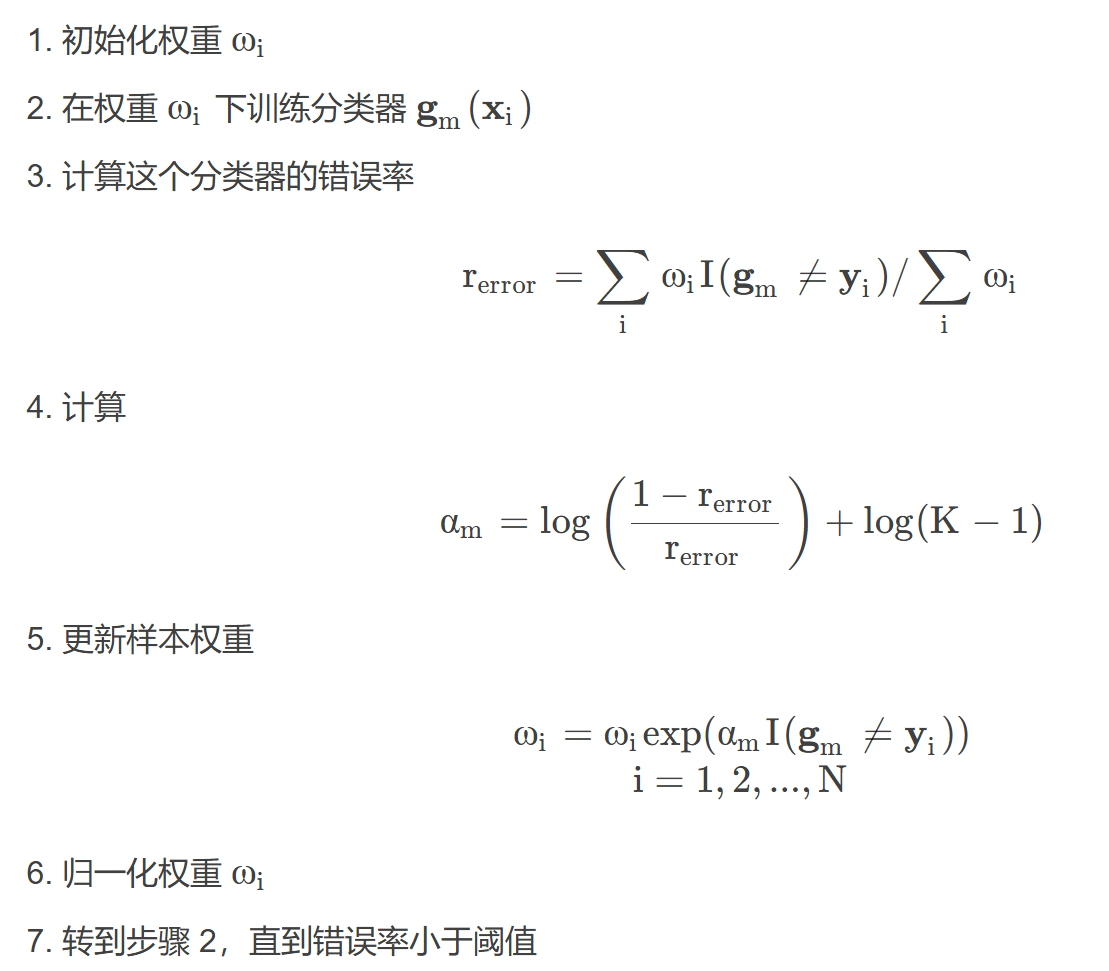


搞定这些以后，这一轮被错分的点占到了更大的权重，下次它当train的时候，投的票就会大一点，这样子实现Adaboost

In [134]:
import math

def adjust_weight(pred_labels,y_test,w_train,w_test,N):   #传入参数N，即分类的总个数，相当于上图中的N
    #方法是，根据上面得到的pred_labels和我的y_test一个分量一个分量对比过去，如果第i个分量不同，就代表第i个数据是归类错误的
    error_index=torch.nonzero(pred_labels-y_test)
   # print("error_index",error_index)
    #先计算分类错误率，error（就是上图中的r_error）
    numerator=0   #分子先设置为0                
    for i in error_index:
      #print("index=",i.item())
      #print("w_test[i.item()]",w_test[i.item()])
      numerator += w_test[i.item()]
      # print("numerator is",numerator)
   
    error = numerator/sum(w_test).item()  #分母是test集中的权重之和，分子是tets集里分错的权重之和
    print("error",error)
   
    #下面计算alpha
    if error >0 and error < 1 :
      alpha = math.log((1-error)/error)+math.log(N-1)   #这里的几段是为了防止分母为0的报错，error得在0,1中间
    #print("alpha",alpha)
    elif error==1:
        alpha=0
    else:          #此时error=0，证明训练很好了,给它安排较大的权重，比如10
        alpha = 10
    #下面更新测试的样本权重，仅仅对于分错的遍历就行了，因为分对的那些权重是不变的（见上面的公式）
    for i in error_index:
      w_test[i.item()]=w_test[i.item()]*math.exp(alpha)
    #print("new wieght",w_test)
    
    #下面归一化权重，此时是将所有的样本一起归一化，要包括train和test两者
    totalsum=sum(w_train)+sum(w_test)
    w_train=w_train/totalsum
    w_test=w_test/totalsum
    #print("new wieght",w_train,w_test)
    return w_train, w_test, alpha

    

In [135]:
# 使用示例
k = 3
x_train = torch.tensor([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0], [1.2, 2.0],[3.2,4.5]])
y_train = torch.tensor([0, 2, 1, 0, 2])
w_train = torch.tensor([0.25,0.25,0.25,0.25,0.25]) #权重，可以自己设置
# print(x_train.size()[0])
x_test = torch.tensor([[2.5, 3.5], [1.0, 2.0],[9.0,22]])
y_test = torch.tensor([2,1,1])
w_test = torch.tensor([0.5,0.25,0.25])
knn = KNN(k)

#print(torch.cdist(x_test, x_train))

pred_labels = knn(x_train, y_train, x_test,w_train)
print(pred_labels)
w_train, w_test ,alpha= adjust_weight(pred_labels,y_test,w_train,w_test,3) #一共3类（目前这个参数还是人数出来的，之后有空再改成自动计类别数好了）
print(alpha)

tensor([2, 0, 2])
error tensor(0.5000)
0.6931471805599453


## 阶段2完成

至此，实现调整权重的函数了，下面的任务是实现滚动，实际上，x_train,x_test等都是自己随机分出来的，本质上他们是一家

In [147]:
import torch

#这是原始输入数据
x_data = torch.tensor([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0], [1.2, 2.0],[3.2,4.5],[2.5, 3.5], [1.0, 2.0],[9.0,22]])
y_data = torch.tensor([0, 2, 1, 0, 2,2,1,1])
w_data = torch.tensor([0.25,0.25,0.25,0.25,0.25,0.5,0.25,0.25]) #权重，可以自己设置

#先打乱
def generate_test_and_train(x_data,y_data,w_data):
    permuted_indices = torch.randperm(x_data.size(0)) #这里取其他的几个也是可以的，反正列数都是一样的
    #print(permuted_indices)
    
    # 使用这个排列对张量进行重新排列
    x_data = x_data[permuted_indices]
    y_data = y_data[permuted_indices]
    w_data = w_data[permuted_indices]
    
    #打乱后把前3个分出去，代表test，剩下的代表train
    
    x_train = x_data[3:]
    y_train = y_data[3:]
    w_train = w_data[3:]
    
    x_test = x_data[:3]
    y_test = y_data[:3]
    w_test = w_data[:3]
    
    #print("随机打乱第0维度后的张量：\n", x_data,y_data,w_data)
    #print(x_test,x_train)
    #print(y_test,y_train)
    return x_train,x_test,y_train,y_test,w_train,w_test #输出一共6个变量

x_train,x_test,y_train,y_test,w_train,w_test = generate_test_and_train(x_data,y_data,w_data)

## 整合代码

下面把所有模块综合起来大致如下：

1. 先使用generate_test_and_train(x_data,y_data,w_data)函数生成训练集与数据集
2. 使用pred_labels = knn(x_train, y_train, x_test,w_train)把当前的最近邻的（加权意义下的）k个算出来，然后指标存在pred_labels里
3. 有了pred_labels后，调用adjust_weight(pred_labels,y_test,w_test,w_train,N)函数，更新权重，别忘记用w_train，w_test再接收一下
4. 现在，w_train，w_test里面是更新好的参数了，别忘记了还有有个beta代表此轮分类器在分类器里的权重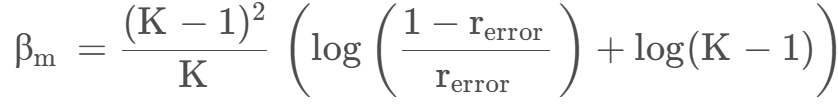但是为了简便，直接用alpha代替好了，只相差常数倍
5. 循环往复
6. 现在，已经有了每一轮的分类器，和每一轮的分类器比重，怎么加起来呢？最终分类器应该是每一个分类器都决策后，乘上各自的alpha再加起来，比如说最终分类器是m个分类器加权的结果，那么用它去预测时，应该各自先根据k近邻，再自己投票得出一个结果，然后再大家把这个结果加权后放到一个大投票池里，大投票池里票数最高的是最后的结果

## 主函数

In [196]:
#主函数在此

import torch

class ModelStructure:
    def __init__(self, tensor1, tensor2, tensor3,tensor4):
        self.tensor1 = tensor1
        self.tensor2 = tensor2
        self.tensor3 = tensor3
        self.tensor4 = tensor4

classifier_array = [] 

def main():
    #这是原始输入数据，自拟
    x_data = torch.tensor([[1.0, -2.0], [-2.0, 3.0], [3.0, 4.0], [1.2, -0.5],[-3.2,4.5],[0.02, 3.5], [1.0, 2.0],[9.0,22],[10,-2],[3,4]])
    y_data = torch.tensor([0, 2, 1, 0, 2,2,1,1,0,1])
    w_data = torch.tensor([0.25,0.25,0.25,0.25,0.25,0.5,0.25,0.25,0.2,0.2]) #权重，可以自己设置

    knn = KNN(2) #knn中k取几
    
    for cnt in range(0,1000):
        
        x_train,x_test,y_train,y_test,w_train,w_test = generate_test_and_train(x_data,y_data,w_data)
        
        pred_labels = knn(x_train, y_train, x_test,w_train)
        
        w_train, w_test,alpha = adjust_weight(pred_labels,y_test,w_train,w_test,3)
        #print("weight_train",w_train,"weight_test",w_test)

        #把这个子分类器存起来，存在一个classifier[]内部，要的就是x_train,y_train,w_train和alpha，这几个量表征了这个子分类器
        classifier_array.append(ModelStructure(x_train,y_train,w_train,alpha))
        
        #把数据集和训练集重新拼起来，以便下一轮打乱
        
        x_data = torch.cat((x_train, x_test), dim=0)
        y_data = torch.cat((y_train, y_test), dim=0)
        w_data = torch.cat((w_train, w_test), dim=0)
       # print(x_data,y_data,w_data )
    
    

main()
print("\n\n Here is my classifier\n")
for item in classifier_array:
    print("x_train:", item.tensor1)
    print("y_train:", item.tensor2)
    print("w_train:", item.tensor3)
    print("alpha:", item.tensor4)

error 0.0
error tensor(1.)
error 0.0
error tensor(0.5000)
error tensor(0.8621)
error 0.0
error tensor(1.)
error 0.0
error tensor(0.6951)
error tensor(0.3571)
error tensor(1.)
error tensor(1.)
error tensor(0.7627)
error tensor(0.7143)
error tensor(1.)
error tensor(0.6923)
error tensor(0.3306)
error tensor(0.8309)
error tensor(0.7426)
error tensor(0.5994)
error tensor(0.5994)
error tensor(0.5668)
error tensor(0.1639)
error tensor(0.4987)
error tensor(0.6789)
error tensor(0.8163)
error tensor(0.8411)
error tensor(0.3088)
error 0.0
error tensor(0.4683)
error 0.0
error tensor(0.1133)
error tensor(0.6819)
error tensor(0.6511)
error tensor(0.6667)
error tensor(0.4825)
error tensor(0.6667)
error tensor(1.)
error tensor(0.8384)
error tensor(0.8557)
error tensor(0.3874)
error tensor(0.8999)
error tensor(1.)
error tensor(0.1292)
error tensor(0.5730)
error tensor(0.2886)
error 0.0
error tensor(0.7906)
error tensor(0.1891)
error tensor(0.7761)
error tensor(1.)
error tensor(0.7867)
error tensor(0.80

## 使用模型

至此，已经训练好模型了，下面那他去分类整个数据集，看看效果如何

In [197]:
def Classify(classifier_array,x_data,y_data):
    #构造一个大投票池
    big_vote_pool = torch.zeros(x_data.size()[0],3) #x_data().size()[0]行3列，3其实是分的类别数，每一行代表考察的样本，那一行就是他的投票池
    
    for subclassifier in classifier_array:
      pred_labels = knn(subclassifier.tensor1, subclassifier.tensor2, x_data , subclassifier.tensor3)
      #这里，带预测的数据就是x_data原本的样本集，而其他三个位置分别是classifier_array中的某一个结构体中的几个张量
      print("pred_labels",pred_labels,"alpha",subclassifier.tensor4)
      for row in range(0,x_data.size()[0]):  #对于每一个样本遍历，此时是某一个固定的子分类器上台投票
          big_vote_pool[row][pred_labels[row]] += subclassifier.tensor4 #投出大小为alpha的一票

    print(big_vote_pool)
    final_decision = torch.argmax(big_vote_pool, dim=1)
    print(final_decision)
    predict_error_index=torch.nonzero(final_decision-y_data)
    print(predict_error_index.size(0))
    print("error rate",predict_error_index.size(0)/final_decision.size(0))

x_data = torch.tensor([[1.0, -2.0], [-2.0, 3.0], [3.0, 4.0], [1.2, -0.5],[-3.2,4.5],[0.02, 3.5], [1.0, 2.0],[9.0,22],[10,-2],[3,4]])
y_data = torch.tensor([0, 2, 1, 0, 2,2,1,1,0,1])
Classify(classifier_array,x_data,y_data)

pred_labels tensor([0, 2, 2, 0, 2, 2, 2, 2, 0, 2]) alpha 10
pred_labels tensor([2, 2, 2, 2, 2, 2, 2, 1, 0, 2]) alpha 0
pred_labels tensor([0, 2, 1, 0, 1, 1, 2, 2, 0, 1]) alpha 10
pred_labels tensor([0, 2, 1, 0, 2, 1, 1, 1, 0, 1]) alpha 0.6931471805599453
pred_labels tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 1]) alpha -1.1394336536145024
pred_labels tensor([2, 2, 1, 2, 2, 2, 2, 1, 0, 1]) alpha 10
pred_labels tensor([2, 2, 2, 2, 2, 2, 2, 1, 0, 2]) alpha 0
pred_labels tensor([2, 2, 1, 2, 2, 1, 1, 1, 0, 1]) alpha 10
pred_labels tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1]) alpha -0.13102881553766066
pred_labels tensor([0, 2, 1, 0, 2, 2, 2, 1, 0, 1]) alpha 1.2809340176532453
pred_labels tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1]) alpha 0
pred_labels tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 1]) alpha 0
pred_labels tensor([0, 2, 1, 0, 2, 2, 2, 1, 0, 1]) alpha -0.4744577518202492
pred_labels tensor([1, 2, 1, 1, 2, 1, 1, 2, 0, 1]) alpha -0.22314331289565914
pred_labels tensor([2, 2, 2, 2, 2, 2, 2, 1, 0, 2]) alpha 0
pre

# 草稿区

下面是草稿纸，用来测试一些用到的函数的

In [ ]:
import torch

# 设置新开的空数组的大小为 (3, 4, 5)
size = (3, )
empty_array = torch.empty(size)
print(empty_array)

In [ ]:
import torch

# 假设你有一个名为 matrix 的张量
matrix = torch.tensor([[1, 2, 3],
                       [4, 12, 6],
                       [7, 8, 9]])

# 使用 torch.argmax 函数找到每一行最大元素所在的列索引
max_indices = torch.argmax(matrix, dim=1)

print(max_indices)  

In [ ]:
import torch

# 假设您有两个张量 tensor1 和 tensor2
tensor1 = torch.tensor([0, 2, 3, 5])
tensor2 = torch.tensor([1, 2, 5, 4])

# 逐一比较两个张量的元素
unequal_indices = torch.nonzero(tensor1-tensor2)

# 打印值不同的列数指标
print(unequal_indices)

In [ ]:
import torch

# 创建一个示例张量
tensor = torch.tensor([
    [[1, 2, 3], [4, 5, 6]],
    [[7, 8, 9], [10, 11, 12]],
    [[13, 14, 15], [16, 17, 18]]
])

# 获取张量的形状
shape = tensor.size()

# 输出第一维度方向的个数
num_samples = shape[0]
print("第一维度方向的个数：", num_samples)

In [ ]:
my=torch.tensor([[1],[2]])
print(my[0])
w_test = torch.tensor([0.25,0.25,0.25])
print(w_test[1])


In [ ]:
import torch

# 创建一个示例张量
tensor = torch.tensor([[1, 2, 3],
                      [4, 5, 6],
                      [7, 8, 9]])

# 生成随机的索引排列
permuted_indices = torch.randperm(tensor.size(0))

print(permuted_indices)
# 使用这个排列对张量进行重新排列
shuffled_tensor = tensor[permuted_indices]

print("随机打乱第0维度后的张量：\n", shuffled_tensor)

In [ ]:
import torch

x_data = torch.tensor([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0], [1.2, 2.0],[3.2,4.5],[2.5, 3.5], [1.0, 2.0],[9.0,22]])

# 将前两个元素划分出去，作为训练集
training_set = x_data[:2]

print("训练集：\n", training_set)

In [ ]:

import torch

# 创建两个示例张量
tensor1 = torch.tensor([[1, 2, 3],
                       [4, 5, 6]])
tensor2 = torch.tensor([[7, 8, 9],
                       [10, 11, 12]])

# 沿着行（维度0）拼接两个张量
concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)
print("沿着行拼接的结果：\n", concatenated_tensor)

# 沿着列（维度1）拼接两个张量
concatenated_tensor = torch.cat((tensor1, tensor2), dim=1)
print("沿着列拼接的结果：\n", concatenated_tensor)

In [ ]:
class CustomStructure:
    def __init__(self, value1, value2):
        self.value1 = value1
        self.value2 = value2

# 创建结构体数组
struct_array = [
    CustomStructure("a", 1),
    CustomStructure("b", 2),
    CustomStructure("c", 3)
]

# 遍历结构体数组
for struct in struct_array:
    print(struct.value1, struct.value2)

In [89]:
print(math.log(2.718))

0.999896315728952
